# Who's the biggest tax evader?

#### Imports:

In [1]:
import plotly.plotly as py
import pandas as pd
import pycountry
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)
# TIM
wb_co2 = pd.read_excel('data/co2_emissions.xls')

In [4]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [5]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [6]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

In [7]:
un_hdi_components_2014 = un_hdi_components_2014[un_hdi_components_2014['Human Development Index (HDI)'] != '..']
un_hdi_components_2014['Human Development Index (HDI)'] = un_hdi_components_2014['Human Development Index (HDI)'].astype('float')

In [8]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

In [9]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

In [10]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [11]:
wb_population_2014 = wb_population_total[['Country Code', '2014']]
occurrence_pop = pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
occurrence_pop['counts_1000'] = 1000 * occurrence_pop['counts'] / occurrence_pop['2014']

In [12]:
# TIM

# We select the rightmost value (most recent) for each row
wb_co2_values = wb_co2.stack().groupby(level=0).last().reindex(wb_co2.index)

# Only select valid values and label other values as NaN
wb_co2['CO2 Emissions'] = pd.to_numeric(wb_co2_values, errors='coerce')

# Only keep most recent values for each country
wb_co2 = wb_co2[['Country Name', 'Country Code', 'CO2 Emissions']]

# Remove countries without indicator information
wb_co2 = wb_co2.dropna()

## 2. Data analysis and observations

### 2.1 Panama Papers and population

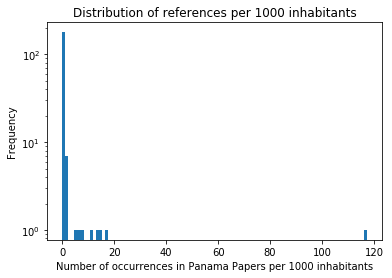

In [13]:
occurrence_pop['counts_1000'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

In [14]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)

We display the distribution using a map:

In [15]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country['country_codes'],
        z = pp_intermediary_country['counts'],
        text = pp_intermediary_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = .3
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

"""
layout = {
  "geo": {
    "coastlinewidth": 2, 
    "countrycolor": "rgb(204, 204, 204)", 
    "lakecolor": "rgb(255, 255, 255)", 
    "landcolor": "rgb(204, 204, 204)", 
    "lataxis": {
      "dtick": 10, 
      "range": [20, 60], 
      "showgrid": True
    }, 
    "lonaxis": {
      "dtick": 20, 
      "range": [-100, 20], 
      "showgrid": True
    }, 
    "projection": {"type": "equirectangular"}, 
    "resolution": 50, 
    "showlakes": True, 
    "showland": False
  }, 
  "showlegend": False, 
  "title": "Seoul to Hong Kong Great Circle"
}

"""
layout = dict(
    title = 'References in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=110,
        showcoastlines = False,
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [16]:
min_count = pp_intermediary_country['counts'].min()
max_count = pp_intermediary_country['counts'].max()

In [17]:
def firstOrDefault(values, default):
    if values is None or len(values) == 0:
        return default
    return values[0]

## 3. Milestone 3

We can see from the tables that most of the countries involved in the Panama Papers affair are small islands, which unfortunately are not displayed by the `Plotly` library. For the next milestone, we will fix that issue either by finding a solution that still works with `Plotly` or by using a different library, such as `folium`.

So far, we have made insightful observations that match the reports found in the media, particularly about which countries were most involved in this affair.

For the next milestone, we will further investigate the links between the countries, and try to understand the correlation of socio-economic factors with the locations of entities, officers and intermediaries involved in Panama Papers. More specifically, we intend to:
- Find which socio-economic factors are correlated with the results we found so far, and how they are correlated
- Display the links between the countries using a graph similar to the one found [here](https://plot.ly/python/lines-on-maps/)
- Fix issues with certain countries (particularly small islands) not being displayed in the graph
-

In [18]:
pp_edges_parsed = pp_edges[['START_ID', 'TYPE', 'END_ID']]

In [19]:
pp_nodes_intermediary_parsed = pp_nodes_intermediary[['node_id', 'country_codes', 'countries']]
pp_nodes_entity_parsed = pp_nodes_entity[['node_id', 'country_codes', 'countries']]
pp_nodes_officer_parsed = pp_nodes_officer[['node_id', 'country_codes', 'countries']]

In [20]:
pp_nodes = pp_nodes_entity_parsed.append(pp_nodes_intermediary_parsed).append(pp_nodes_officer_parsed)
pp_nodes = pp_nodes.dropna()

In [21]:
pp_edges_countries = pp_nodes.merge(pp_edges_parsed, left_on='node_id', right_on='START_ID')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_origin', 'country_codes': 'cc_origin', 
                                                        'countries': 'c_origin'})
pp_edges_countries = pp_edges_countries.merge(pp_nodes, left_on='END_ID', right_on='node_id')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_dest', 'country_codes': 'cc_dest', 
                                                        'countries': 'c_dest'})
pp_edges_countries = pp_edges_countries.drop(columns=['id_origin', 'id_dest'])

## Scatter plot 

In [22]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [23]:
pp_references_country.head()

,country_codes,countries,counts
0,ABW,Aruba,18
1,AGO,Angola,38
2,AIA,Anguilla,105
3,ALB,Albania,23
4,AND,Andorra,35


In [24]:
def count_occurence(pp_data):
    return pp_data.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [25]:
pp_references_country = count_occurence(pp_nodes_address)

In [26]:
pp_references_country.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,20267
75,HKG,Hong Kong,9147
61,GBR,United Kingdom,3996
193,VGB,British Virgin Islands,3467
155,RUS,Russia,3346


In [27]:
pp_references_officier = count_occurence(pp_nodes_officer)
pp_references_officier.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069


In [28]:
pp_references_entity = count_occurence(pp_nodes_entity)
pp_references_entity.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840


In [29]:
pp_references_intermediary = count_occurence(pp_nodes_intermediary)
pp_references_intermediary.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


In [30]:
pp_references_total = pp_references_intermediary.merge(pp_references_entity, on='country_codes')
pp_references_total = pp_references_total.merge(pp_references_officier, on='country_codes')
pp_references_total['counts'] = pp_references_total['counts'] + pp_references_total['counts_x'] + pp_references_total['counts_y']

In [31]:
gdp_2015 = un_gdp_per_capita[un_gdp_per_capita['Year'] == 2015][['CODE', 'Value']]

In [32]:
gdp_2015.head()

,CODE,Value
1,AFG,610.854517
48,ALB,3877.487975
95,DZA,4160.218690
142,AND,36039.907860
189,AGO,4133.025039


In [33]:
pp_references_country.head(1)

,country_codes,countries,counts
0,ABW,Aruba,18


In [34]:
wb_population_2014.head(1)

,Country Code,2014
0,ABW,103795.0


In [35]:
nodes_types = [pp_references_entity, pp_references_intermediary, pp_references_officier, pp_references_total]
nodes_types_desc = ['Entity references', 'Intermediary references', 'Officier references', 'Total references']


In [36]:
pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')[['country_codes', 'countries', 'counts', '2014']].head(1)


,country_codes,countries,counts,2014
0,ABW,Aruba,18,103795.0


In [37]:
def normalize_count(df):
    merged = df.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')[['country_codes', 'countries', 'counts', '2014']]
    merged['counts_normalized'] = merged['counts'] / merged['2014']
    return merged

In [38]:
nodes_types_normalized = list(map(normalize_count, nodes_types))

In [39]:
gdp_data = [x[(x['counts'] < 200000)].merge(gdp_2015[gdp_2015['Value'] < 400000], left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]


In [40]:
def plot_all_entity(data, x_name, y_name, data_name, index_activated, title, x_label, y_label, save_name):
    traces = []
    i = 0
    for d in data:
        # Create a trace
        trace = go.Scatter(
            name = data_name[i],
            x = d[x_name],
            y = d[y_name],
            mode = 'markers',
            text = d['countries'],
            visible = 'legendonly' if i != index_activated else True
        )
        traces.append(trace)
        
        corr, p = stats.pearsonr(d[x_name], d[y_name])
        print(data_name[i])
        print('\tpearson : ', corr, '; p-val: ', p)
        corr, p = stats.spearmanr(d[x_name], d[y_name])
        print('\tspearman : ', corr, '; p-val: ', p)
        i+=1
    data = traces
    
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=x_label
        ),
        yaxis=dict(
            title=y_label
        ),
        hovermode = 'closest'
    )
    fig = go.Figure(data=data, layout=layout)
    file_path = '../TrovatelliT.github.io/ressources/' + save_name
    iplot(fig)
    plot(fig, filename=file_path, auto_open=False)


In [89]:
plot_all_entity(gdp_data, 'counts', 'Value', nodes_types_desc, 3, 'Occurrences vs GDP', 'Occurrences', 'GDP per capita', 'scatter_gdp_count.html')


Entity references
	pearson :  0.27890576533476313 ; p-val:  0.0005722944570258768
	spearman :  0.5222010761126317 ; p-val:  8.481269373710362e-12
Intermediary references
	pearson :  0.24034244025487464 ; p-val:  0.0060782412790784815
	spearman :  0.5314197132075454 ; p-val:  9.201082760772482e-11
Officier references
	pearson :  0.1440349311294215 ; p-val:  0.04860604100459834
	spearman :  0.5233686240547055 ; p-val:  1.2993273758590661e-14
Total references
	pearson :  0.2470717432817822 ; p-val:  0.004929525079904911
	spearman :  0.437214945213794 ; p-val:  2.46777017037563e-07


In [90]:
plot_all_entity(gdp_data, 'counts_normalized', 'Value', nodes_types_desc, 3, 'Occurrences vs GDP', 'Occurrences', 'GDP per capita', 'scatter_gdp_count_normalized.html')


Entity references
	pearson :  0.6510367995714508 ; p-val:  2.50890788369854e-19
	spearman :  0.6285766629575078 ; p-val:  9.292196238974889e-18
Intermediary references
	pearson :  0.7150706906732729 ; p-val:  1.7554539226167704e-21
	spearman :  0.6451568721451854 ; p-val:  1.553788694580932e-16
Officier references
	pearson :  0.12722984052011616 ; p-val:  0.08187113641492019
	spearman :  0.6855479005810181 ; p-val:  1.9385852679536105e-27
Total references
	pearson :  0.2756285377623522 ; p-val:  0.0016381828103720743
	spearman :  0.5952072010729874 ; p-val:  1.2687783517313314e-13


We'll now focus on entity occurrences

In [42]:
def remove_outliers(data, field):
    Q1 = data[field].quantile(0.25)
    Q3 = data[field].quantile(0.75)
    IQR = Q3 - Q1

    return data[(data[field] < Q3 + 1.5 * IQR) & (data[field] > Q1 - 1.5 * IQR)]

In [43]:
def remove_outliers_2(data, field1, field2):
    Q1_1 = data[field1].quantile(0.25)
    Q3_1 = data[field1].quantile(0.75)
    IQR_1 = Q3_1 - Q1_1
    
    Q1_2 = data[field2].quantile(0.25)
    Q3_2 = data[field2].quantile(0.75)
    IQR_2 = Q3_2 - Q1_2

    filter1 = (data[field1] < Q3_1 + 1.5 * IQR_1) & (data[field1] > Q1_1 - 1.5 * IQR_1)
    filter2 = (data[field2] < Q3_2 + 1.5 * IQR_2) & (data[field2] > Q1_2 - 1.5 * IQR_2)
    return data[filter1 & filter2]

In [44]:
data = list(map(lambda d: remove_outliers_2(d, 'Value', 'counts_normalized'), gdp_data))
plot_all_entity(data, 'counts_normalized', 'Value', nodes_types_desc, 3, 'Total occurrences vs GDP', 'Occurrences', 'GDP per capita', 'scatter_gdp_count_outlier.html')


Entity references
	pearson :  0.23129683833119966 ; p-val:  0.012484761903557129
	spearman :  0.6035455417409022 ; p-val:  7.450214102079221e-13
Intermediary references
	pearson :  0.3636282919870751 ; p-val:  0.00014810946790924493
	spearman :  0.6185602756884151 ; p-val:  2.6120917820835085e-12
Officier references
	pearson :  0.4362808144227363 ; p-val:  3.699496314204286e-08
	spearman :  0.6584449099565494 ; p-val:  1.6878406678485969e-19
Total references
	pearson :  0.12165059315598446 ; p-val:  0.23033496857175298
	spearman :  0.5385112508104001 ; p-val:  8.959416567754556e-09


In [45]:
gini_nan = wb_gini.dropna()

In [46]:
gini_data = [x[x['counts'] > 0].merge(gini_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]

In [47]:
gini_data[0].head(2)

,country_codes,countries,counts,2014,counts_normalized,Country Name,Country Code,Gini
0,AGO,Angola,10,26920466.0,3.714646e-07,Angola,AGO,42.7
1,ALB,Albania,2,2889104.0,6.922561e-07,Albania,ALB,29.0


In [72]:
plot_all_entity(gini_data, 'counts', 'Gini', nodes_types_desc, 0, 'Total occurrences vs Gini Index', 'Occurrences', 'Gini', 'scatter_gini_count.html')

Entity references
	pearson :  -0.017776835669333347 ; p-val:  0.8524161507208763
	spearman :  0.00860071904431001 ; p-val:  0.9282856318098072
Intermediary references
	pearson :  0.05812950070252046 ; p-val:  0.5716888824147901
	spearman :  0.073677142388402 ; p-val:  0.4732479822777369
Officier references
	pearson :  0.08393271001275916 ; p-val:  0.32240817000097954
	spearman :  -0.0014589414496253123 ; p-val:  0.9863011812502918
Total references
	pearson :  0.03899012338843793 ; p-val:  0.7060526383890481
	spearman :  0.08363772029357229 ; p-val:  0.417845325169529


In [75]:
data = list(map(lambda d: remove_outliers_2(d, 'Gini', 'counts_normalized'), gini_data))
plot_all_entity(data, 'counts_normalized', 'Gini', nodes_types_desc, 3, 'Total occurrences vs Gini', 'Occurrences', 'Gini Index', 'scatter_gini_count_outlier.html')


Entity references
	pearson :  0.022208972975518916 ; p-val:  0.834481706699075
	spearman :  -0.06677284496632857 ; p-val:  0.5294345944306046
Intermediary references
	pearson :  -0.04743163124534681 ; p-val:  0.6741300964898189
	spearman :  -0.08680628118265445 ; p-val:  0.44096197801827186
Officier references
	pearson :  -0.02830459460806839 ; p-val:  0.7579450080938033
	spearman :  -0.06955325908506865 ; p-val:  0.4484133031891383
Total references
	pearson :  -0.027051310386034675 ; p-val:  0.8177976273022307
	spearman :  -0.09558222096389055 ; p-val:  0.41465273285911763


In [51]:
len(wb_income_share_20_per)

264

In [52]:
wb_income_share_nan = wb_income_share_20_per.dropna()

In [53]:
wb_income_share_nan.head(2)

,Country Name,Country Code,Income Share
2,Angola,AGO,48.5
3,Albania,ALB,37.8


In [54]:
income_share_data = [x[x['counts'] > 0].merge(wb_income_share_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types_normalized]


In [55]:
income_share_data[2].corr()

,counts,2014,counts_normalized,Income Share
counts,1.000000,0.666306,0.073596,0.068002
2014,0.666306,1.000000,-0.043874,0.033179
counts_normalized,0.073596,-0.043874,1.000000,0.087071
Income Share,0.068002,0.033179,0.087071,1.000000


In [56]:
plot_all_entity(income_share_data, 'counts', 'Income Share')

TypeError: plot_all_entity() missing 6 required positional arguments: 'data_name', 'index_activated', 'title', 'x_label', 'y_label', and 'save_name'

In [88]:
plot_all_entity(income_share_data, 'counts_normalized', 'Income Share', nodes_types_desc, 3, 'Total occurrences vs 20%', 'Occurrences', 'top 20', 'scatter_20_count.html')


Entity references
	pearson :  -0.004802282654410256 ; p-val:  0.959921002512693
	spearman :  -0.08308880387654578 ; p-val:  0.3837695080636022
Intermediary references
	pearson :  -0.05508450656526783 ; p-val:  0.5920320963999854
	spearman :  -0.081000756367968 ; p-val:  0.43027555444025123
Officier references
	pearson :  0.08707100597960614 ; p-val:  0.30458118403756707
	spearman :  -0.07941740604052067 ; p-val:  0.3492142000835745
Total references
	pearson :  0.0416621792103389 ; p-val:  0.6869245998315479
	spearman :  -0.08073038569839779 ; p-val:  0.4342681565075649


In [86]:
data = list(map(lambda d: remove_outliers_2(d, 'counts_normalized', 'Income Share'), income_share_data))
plot_all_entity(data, 'counts_normalized', 'Income Share', nodes_types_desc, 3, 'Total occurrences vs 20%', 'Occurrences', 'top 20', 'scatter_20_count_outliers.html')


Entity references
	pearson :  0.020118388348656053 ; p-val:  0.8507113344738853
	spearman :  -0.13089882361978766 ; p-val:  0.21878856713695718
Intermediary references
	pearson :  -0.08001817692149342 ; p-val:  0.47763587921380724
	spearman :  -0.15917201257475747 ; p-val:  0.1557973105729123
Officier references
	pearson :  -0.03856234382657333 ; p-val:  0.6745300237214964
	spearman :  -0.12611105130829123 ; p-val:  0.168100859743007
Total references
	pearson :  -0.05823303695554936 ; p-val:  0.6197081921442793
	spearman :  -0.17189478411666026 ; p-val:  0.1403066847823988


In [59]:
un_hdi_components_2014.head(1)

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,CODE
0,1,Norway,0.944,81.6,17.5,12.6,64992,5,NOR


In [60]:
hdi_data = [x.merge(un_hdi_components_2014, left_on='country_codes', right_on='CODE') for x in nodes_types_normalized]


In [64]:
plot_all_entity(hdi_data, 'counts_normalized', 'Human Development Index (HDI)', nodes_types_desc, 3, 'Total occurrences vs HDI', 'Occurences', 'HDI Index', 'scatter_gdi_count.html')

Entity references
	pearson :  0.16542881432746046 ; p-val:  0.05337362203673549
	spearman :  0.5248900880421896 ; p-val:  4.572232793496284e-11
Intermediary references
	pearson :  0.15816274506454447 ; p-val:  0.08446828307914006
	spearman :  0.5027650501051069 ; p-val:  4.867514779852806e-09
Officier references
	pearson :  0.13857823984748885 ; p-val:  0.06902112288446911
	spearman :  0.6180827450080844 ; p-val:  1.311368891067031e-19
Total references
	pearson :  0.15569323301643107 ; p-val:  0.0908726212935562
	spearman :  0.4673155779279991 ; p-val:  8.418128309964871e-08


In [67]:
data = list(map(lambda d: remove_outliers_2(d, 'Human Development Index (HDI)', 'counts_normalized'), hdi_data))
plot_all_entity(data, 'counts_normalized', 'Human Development Index (HDI)', nodes_types_desc, 3, 'Total occurrences vs HDI', 'Occurrences', 'HDI Index', 'scatter_hdi_count_outlier.html')


Entity references
	pearson :  0.2408578893332109 ; p-val:  0.011639242465805177
	spearman :  0.5308067635418598 ; p-val:  2.898835128865019e-09
Intermediary references
	pearson :  0.30928860299877114 ; p-val:  0.0019425894839390943
	spearman :  0.5196789149636303 ; p-val:  4.171432225610701e-08
Officier references
	pearson :  0.45587227382986545 ; p-val:  6.543257709460018e-09
	spearman :  0.6205223819031734 ; p-val:  5.177718075083676e-17
Total references
	pearson :  0.23480729070912107 ; p-val:  0.021995627233654214
	spearman :  0.48046530551766936 ; p-val:  8.324509404392334e-07
